## Upsell 모델 remodeling

In [1]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query


from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

## load data

In [4]:
df = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201910.pkl'))

In [5]:
df.shape

(19682423, 80)

## load model

In [6]:
with open(os.path.join(DATA_PATH, 'upsell_new_model_2.pkl'), 'rb') as f:
    clf = pickle.load(f)

## predict

In [7]:
df_score = df[['svc_mgmt_num']]

In [8]:
label_cols = [c for c in df.columns if 'label_' in c]

# columns
idx_col = 'svc_mgmt_num'
target_col = 'label_upsell_yn'
del_cols = [idx_col, target_col, 'ym'] 
del_cols += label_cols
feature_cols = [col for col in df.columns if col not in del_cols]

In [9]:
df_score['score'] = clf.predict(df[feature_cols])

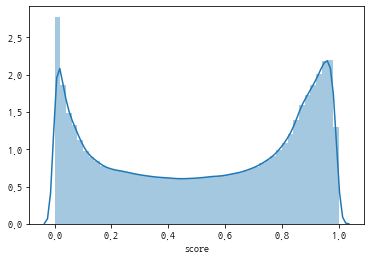

In [10]:
import seaborn as sns
sns.distplot(df_score['score'])

In [11]:
df_score['prod_id'] = 'RC00000001'
df_score['prod_nm'] = '요금제업셀가망'
df_score['score'] = np.round(df_score.score, 4)
df_score['reco_type'] = 'upsell'
df_score['model'] = 'dominic_lgbm_20191104'
df_score['dt'] = '20191104'

In [12]:
df_score.sort_values('score', ascending=False).head(20)

svc_mgmt_num   score     prod_id  prod_nm reco_type  \
5983    7226017119  0.9998  RC00000001  요금제업셀가망    upsell   
59371   1668926200  0.9998  RC00000001  요금제업셀가망    upsell   
14061   7278439286  0.9997  RC00000001  요금제업셀가망    upsell   
70616   7269307738  0.9997  RC00000001  요금제업셀가망    upsell   
39607   1490029408  0.9995  RC00000001  요금제업셀가망    upsell   
93281   7286310579  0.9995  RC00000001  요금제업셀가망    upsell   
30726   7260680382  0.9995  RC00000001  요금제업셀가망    upsell   
55679   7295341106  0.9995  RC00000001  요금제업셀가망    upsell   
92435   7285590855  0.9995  RC00000001  요금제업셀가망    upsell   
15437   7287306435  0.9995  RC00000001  요금제업셀가망    upsell   
15841   7287859937  0.9995  RC00000001  요금제업셀가망    upsell   
66126   7239568724  0.9995  RC00000001  요금제업셀가망    upsell   
76510   7302084449  0.9994  RC00000001  요금제업셀가망    upsell   
30909   7262609567  0.9994  RC00000001  요금제업셀가망    upsell   
70389   7268304366  0.9993  RC00000001  요금제업셀가망    upsell   
94327   7291526558  0.9993  RC00000001  요금제업셀가망    upsell   
43958   7214834605  0.9993  RC00000001  요금제업셀가망    upsell   
28626   7248824670  0.9993  RC00000001  요금제업셀가망    upsell   
29259   7251656508  0.9993  RC00000001  요금제업셀가망    upsell   
90959   7270941926  0.9993  RC00000001  요금제업셀가망    upsell   

                       model        dt  
5983   dominic_lgbm_20191104  20191104  
59371  dominic_lgbm_20191104  20191104  
14061  dominic_lgbm_20191104  20191104  
70616  dominic_lgbm_20191104  20191104  
39607  dominic_lgbm_20191104  20191104  
93281  dominic_lgbm_20191104  20191104  
30726  dominic_lgbm_20191104  20191104  
55679  dominic_lgbm_20191104  20191104  
92435  dominic_lgbm_20191104  20191104  
15437  dominic_lgbm_20191104  20191104  
15841  dominic_lgbm_20191104  20191104  
66126  dominic_lgbm_20191104  20191104  
76510  dominic_lgbm_20191104  20191104  
30909  dominic_lgbm_20191104  20191104  
70389  dominic_lgbm_20191104  20191104  
94327  dominic_lgbm_20191104  20191104  
43958  dominic_lgbm_20191104  20191104  
28626  dominic_lgbm_20191104  20191104  
29259  dominic_lgbm_20191104  20191104  
90959  dominic_lgbm_20191104  20191104

## submit

In [13]:
conn = hive_connection('dmig')
send_query(conn, 'drop table dumbo.item_reco_predict_dominic')

2019-11-05 13:34:06,781 - YE_HIVE - INFO - Query 'drop table dumbo.item_reco_predict_dominic' is done


In [14]:
conn = hive_connection('dmig')
load_to_hive(conn, 
             df_score[['svc_mgmt_num', 'prod_id', 'prod_nm', 'score', 'reco_type', 'model', 'dt']], 
             'dumbo.item_reco_predict_dominic')

2019-11-05 13:34:14,673 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_predict_dominic (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, dt string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-11-05 13:34:14,691 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-11-05 13:35:56,931 - YE_HIVE - INFO - Loading data to HDFS... 
2019-11-05 13:36:19,184 - YE_HIVE - INFO - Loading to table dumbo.item_reco_predict_dominic is done


## check 후 insert

In [15]:
insert_sql = """
INSERT  OVERWRITE TABLE comm.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.item_reco_predict_dominic
"""

In [16]:
conn = hive_connection('dmig')
send_query(conn, insert_sql)

2019-11-05 13:39:13,202 - YE_HIVE - INFO - Query '
INSERT  OVERWRITE TABLE comm.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.item_reco_predict_dominic
' is done


In [17]:
save_model(clf, 'dominic_lgbm_20191104')

save model to  /home/dmig/work/upsell/model/dominic_lgbm_20191104


In [18]:
pd.DataFrame({'feature': clf.feature_name(), 
             'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(50)

feature  importance
6            last_equip_period        2993
1                          age        2810
7                  bas_fee_amt        2715
53            data_usage_ratio        2153
54  bf_m6_data_usage_ratio_avg        2115
5              svc_scrb_period        2063
3              mng_nice_cb_scr        1932
44     avg_subscription_period        1917
46             real_arpu_bf_m1        1699
48             real_arpu_bf_m3        1638
8              bas_ofr_data_gb        1606
28      data_usage_in_gb_bf_m2        1582
27      data_usage_in_gb_bf_m1        1519
26      data_usage_in_gb_bf_m0        1444
47             real_arpu_bf_m2        1382
10               allot_prn_amt        1273
11               pmth_inv_bamt        1204
45            avg_chg_duration        1162
49               real_avg_arpu        1150
29        avg_data_usage_in_gb         956
51  bf_m6_sum_data_usage_in_gb         944
43             avg_mbr_use_cnt         937
52  bf_m6_avg_data_usage_in_gb         880
78                     channel         581
30                 overage_bf0         470
0                       sex_cd         454
57           copn_left_cnt_bf0         451
50           bf_m3_fee_chg_cnt         427
31                 overage_bf1         422
59           copn_left_cnt_bf2         402
25  ref_data_usage_in_gb_bf_m2         386
24  ref_data_usage_in_gb_bf_m1         367
55   bf_m6_data_over_usage_cnt         359
32                 overage_bf2         344
58           copn_left_cnt_bf1         339
17          avg_twld_visit_cnt         337
4              mng_nice_cb_grd         332
16        twld_visit_cnt_bf_m2         316
69          mth_cnsl_cnt_bf_m0         308
2                       svc_gr         295
12                   family_yn         278
71          mth_cnsl_cnt_bf_m2         241
56   bf_m3_data_over_usage_cnt         239
75    simpl_ref_cnsl_cnt_bf_m0         234
70          mth_cnsl_cnt_bf_m1         203
22                    ansim_yn         191
76    simpl_ref_cnsl_cnt_bf_m1         179
77    simpl_ref_cnsl_cnt_bf_m2         175
36     data_gift_send_yn_bf_m0         174
13             family_small_yn         153